 This jupiter notebook is based on the following article: *R. Naidoo, S. Baboolal, Application of the Kurganov–Levy semi-discrete numerical scheme to hyperbolic problems with nonlinear source terms, https://www.sciencedirect.com/science/article/abs/pii/S0167739X03001870*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate

In [ ]:
def getConserved( rho, ux, vol):
    """
    Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    ux       is matrix of cell x-vel
    """
    Mass   = rho * vol
    Momx   = rho * ux

    return Mass, Momx

In [ ]:
def local_propagation_speed(rho, ux):

   '''
    Get the local propagation speeds using the eigenvalues
    of the flux matrix of the non relativistic IS equations

    rho          is a matrix of left-state  density
    ux           is a matrix of x-velocity
    z            is a matrix of flux
    '''

   C = np.abs(1/2 * ux) + np.sqrt(4*rho + ux**2)

   return C


In [ ]:
def Euler(q , C , dt):
    '''
    Foward Euler timestep

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep


    '''
    E = q + dt * C

    return E


def modified_RungeKutta(q, C, dt, s=2):

    '''
    Modified Runge-Kutta integrator

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep
    s   is the optional parameter for the order of the integrator

    This integrator goes up to 3 order

    This function updates the q field by one timestep using the numerical
    derivative of q over time (Heun's Method)
    '''

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty((s,A,B))
    except:
      y = np.empty((s,A))


    if s==2:

      y[0] = Euler(q,C,dt) # foward euler step
      y[1] = 0.5 * q + 0.5*Euler(y[0],C,dt)

    if s==3:
      pass

    return y[s-1]

def modified_RungeKutta(q, C, dt, s=2):

    bl = 0.5

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty([s,A,B])
    except:
      y = np.empty([s,A])

    y[0:] = Euler(q,C,dt) # foward euler step

    for i in range(s):
        y[i] = bl * q + (1 - bl)*Euler(y[0],C,dt)

    return y[s-1]

In [ ]:
def extrapolateInSpaceQuadratic(q, dx):

  """
  Calculate the gradients of a field
  q        is a matrix of the field
  A        is the constant term
  B        is linear term
  C        is quadratic term
  dx       is the cell size
  q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
  q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
  """
  # directions for np.roll()
  R = -1   # right
  L = 1    # left


  qP_XL = A(q,dx) - B(q,dx) * dx/2 + C(q,dx) * dx**2 / 8
  qP_XR = np.roll(A(q,dx),R,axis=0) - np.roll(B(q,dx),R,axis=0) * dx/2  + np.roll(C(q,dx),R,axis=0) * dx**2 / 8
  qM_XR = A(q,dx) + B(q,dx) * dx/2 + C(q,dx) * dx**2 / 8
  qM_XL = np.roll(A(q,dx),L,axis=0) + np.roll(B(q,dx),L,axis=0) * dx/2  + np.roll(C(q,dx),L,axis=0) * dx**2 / 8


  return qM_XL, qP_XL, qM_XR, qP_XR


def A(f,dx):

  wr, wc, wl = w(f)

  R = -1
  L =  1

  A = f - (wc / 12) * (np.roll(f,R,axis=0) - 2 * f + np.roll(f,L,axis=0))

  return A


def B(f,dx):

  wr, wc, wl = w(f)

  R = -1
  L =  1

  B = (wr * (np.roll(f,R,axis=0) - f) + wc * (np.roll(f,R,axis=0)- np.roll(f,L,axis=0)) * 0.5 +  wl * (f - np.roll(f,L,axis=0))) / dx

  return B

def C(f,dx):

  wr, wc, wl = w(f)

  R = -1
  L =  1

  C =  (wc / dx**2) * (np.roll(f,R,axis=0) - 2 * f + np.roll(f,L,axis=0))

  return C

def w(f,p=2):

  R = -1
  L =  1

  n = f.shape[0]
  epsilon = 10**(-6) * np.ones((3,n))

  c = np.array([1/4,1/2,1/4])

  C = np.zeros((3,n))

  for i in range(n):
    C[0][i] = c[0]
    C[1][i] = c[1]
    C[2][i] = c[2]

  IS = np.array([(f- np.roll(f,L,axis=0))**2,
                 13/3 * (np.roll(f,R,axis=0) - 2 * f + np.roll(f,L,axis=0))**2
                 + 1 / 4 * (np.roll(f,R,axis=0)- np.roll(f,L,axis=0))**2,
                 (np.roll(f,R,axis=0) - f)**2])

  a = C / (epsilon + IS)**p

  w = a / np.sum(a)

  return w




In [ ]:
def getFlux(rho_P, rho_M, ux_P, ux_M, z_P, z_M):

  """

  Calculate fluxes between 2 states with local Kurganov Levy rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  ux_P         is a matrix of left-state  x-velocity
  ux_M         is a matrix of right-state x-velocity
  z_P          is a matrix of left-state bulk viscosity
  z_M          is a matrix of right-state bulk viscosity
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_z       is the matrix of the bulk viscosity var

  """


  # compute (averaged) states over the left and right states
  momx_av  = 0.5*(rho_P * ux_P + rho_M * ux_M)
  z_av     = 0.5*(z_P + z_M)

  # compute fluxes (local Kurganov-Levy)

  flux_Mass   = momx_av
  flux_Momx   = z_av
  flux_z      = momx_av

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , ux_P) # max propagation speed from the left
  C_M = local_propagation_speed(rho_M , ux_M) # max propagation speed from the right
  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * ux_P - rho_M * ux_M)
  flux_z      -= C * 0.5 * ( z_P - z_M )

  return flux_Mass, flux_Momx, flux_z

In [ ]:
def applyFluxes(flux_H1_X, flux_H2_X , dx, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    dx        is the cell size
    """
    C = 0
    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C += J

    return C

Broadwell gas


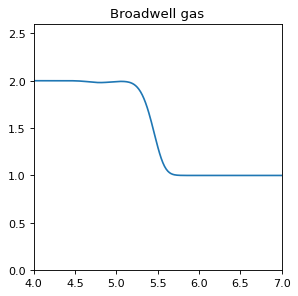

This is the evolved solution


<Figure size 640x480 with 0 Axes>

In [ ]:
def main():
    """ Finite Volume simulation """

    # Simulation parameters
    N                      = 1000 # resolution
    boxsize                = 10.  # in some unit system l
    e                      = 0.001   # mean free path
    t                      = 0   # s
    tEnd                   = 0.5   # time at the end
    tOut                   = 0.01 # time of each output

    plotRealTime = False  # switch on for plotting as the simulation goes along

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Define Mesh
    dx = boxsize / N   # box size
    vol = dx**2        # volume of each box
    xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N) # simulation limits


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho1 = 2*(xlin < 5) + 1*(xlin >= 5 )
    #rho1 = 1*(xlin < 5) + 0.2*(xlin >= 5 )

    ''' Initial conditions for v'''

    ux1  = 1/2 * (xlin < 5) + 0.13962*(xlin >= 5)
    #ux1  = 0 * (xlin < 5) + 0 * (xlin >= 5)


    ''' flux initial condition '''

    z1 = np.ones(xlin.shape)
    #z1 = np.ones(xlin.shape)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # average mass
    M1 = np.sum(rho1*vol)

    # array that stores the times at which the values are calculated
    times = np.array([t])

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # prep figure
    fig = plt.figure(figsize=(4,4), dpi=80)
    outputCount = 1

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # Simulation Main Loop
    while t < tEnd:

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get Conserved variables
        Mass1, Momx1 = getConserved(rho1, ux1, vol)

        M1 = np.vstack((M1, np.sum(Mass1)))


        if np.any(Mass1 < 0):
          print("Mass is negative", t)


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get time step

        # condition to ensure that the time steps are small enough so that
        # waves do not interfere with each other
        courant_number1 = np.min(dx/local_propagation_speed(rho1, ux1))

        dt1 = np.minimum(0.01, 0.1*courant_number1)
        #print(dt)

        times = np.hstack((times, t + dt1))

        plotThisTurn = False

        if t + dt1 > outputCount*tOut:
            plotThisTurn = True

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # extrapolate in space to face centers

        rho1M_XL, rho1P_XL, rho1M_XR, rho1P_XR = extrapolateInSpaceQuadratic(rho1, dx)
        ux1M_XL,  ux1P_XL,  ux1M_XR,  ux1P_XR  = extrapolateInSpaceQuadratic(ux1,  dx)
        z1M_XL,   z1P_XL,   z1M_XR,   z1P_XR   = extrapolateInSpaceQuadratic(z1,   dx)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # compute fluxes (local Kurganov-Levy)

        flux_Mass1_XR, flux_Momx1_XR, flux_z1_XR = getFlux(rho1P_XR, rho1M_XR, ux1P_XR, ux1M_XR, z1P_XR, z1M_XR)
        flux_Mass1_XL, flux_Momx1_XL, flux_z1_XL = getFlux(rho1P_XL, rho1M_XL, ux1P_XL, ux1M_XL, z1P_XL, z1M_XL)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update solution


        J1 =  1/e * (rho1 ** 2 + Momx1 ** 2 - 2 * z1 * rho1 )

        rho1    = modified_RungeKutta(rho1,   applyFluxes( flux_Mass1_XR,   flux_Mass1_XL,   dx),    dt1)
        ux1      = np.divide(modified_RungeKutta(Momx1,  applyFluxes( flux_Momx1_XR,   flux_Momx1_XL,   dx),    dt1), rho1,
                         out=np.zeros_like(modified_RungeKutta(Momx1,  applyFluxes( flux_Momx1_XR,   flux_Momx1_XL,   dx), dt1)), where=rho1!=0)
        z1      = modified_RungeKutta(z1, applyFluxes( flux_z1_XR,    flux_z1_XL,    dx, J1), dt1)


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # Boundary conditions


        '''Absorbing boundary conditions'''

        rho1[0]    = rho1M_XL[1]
        rho1[-1]   = rho1P_XR[-2]

        ux1[0]     = ux1M_XL[1]
        ux1[-1]    = ux1P_XR[-2]

        z1[0]      = z1M_XL[1]
        z1[-1]     = z1P_XR[-2]


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update time
        t += dt1

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # plot in real time
        if (plotRealTime and plotThisTurn) or (t >= tEnd):
            plt.cla()
            plt.plot(xlin,rho1,)
            plt.title('Broadwell gas')
            plt.xlim((4,7))
            plt.ylim(0,2.5+0.1)
            plt.pause(0.001)
            outputCount += 1
       #-----------------------------------------------------------------------------------------------------------------------------------#



    # Save figure
    plt.savefig('finitevolume.png',dpi=240)
    print("This is the evolved solution")
    plt.show()

    return 0



if __name__== "__main__":
  print("Broadwell gas")
  main()
